In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP

from advectionGP.models import AdjointAdvectionDiffusionModel as PDEModel

from advectionGP.wind import WindSimple, WindFixU#Wind model


from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt
import numpy.random as rd
rd.seed(123)

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,9,5) # lower time
xloc=np.linspace(1,9,4) # x locations
yloc=np.linspace(1,9,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

XGP= np.zeros((sensN*obsN,3))
XGP[:,0] = (X[:,0]+X[:,1])/2
XGP[:,1] = X[:,2]
XGP[:,2] = X[:,3] 

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

In [3]:
k_0 = 0.01 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,50,50] # grid size for time, x and y


u1 = 0.04
u2 = 0.04
windmodel=WindSimple(u1,u2) # establish fixed wind model

#wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.5
#u=[]
#u.append(np.ones(res)*wind) #x direction wind
#u.append(np.ones(res)*0.0) # y direction wind
#windmodel=WindFixU(u)

m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

In [4]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations

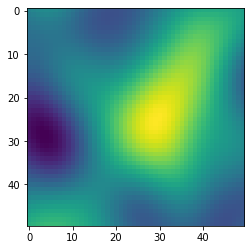

In [5]:
plt.imshow(sourceGT[9])

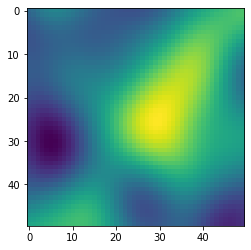

In [6]:
plt.imshow(concTrain[9])

In [7]:
X.shape

(80, 4)

In [8]:
yTrain.shape

(80,)

In [9]:
FullObs = np.hstack((X,yTrain[:,None]))

In [10]:
FullObs

array([[  1.        ,   1.1       ,   1.        ,   1.        ,
         -0.63392359],
       [  1.        ,   1.1       ,   1.        ,   3.66666667,
         -0.66183892],
       [  1.        ,   1.1       ,   1.        ,   6.33333333,
         -0.08342062],
       [  1.        ,   1.1       ,   1.        ,   9.        ,
          1.21737623],
       [  3.        ,   3.1       ,   1.        ,   1.        ,
         -1.56960399],
       [  3.        ,   3.1       ,   1.        ,   3.66666667,
         -3.70723848],
       [  3.        ,   3.1       ,   1.        ,   6.33333333,
          0.15371943],
       [  3.        ,   3.1       ,   1.        ,   9.        ,
          3.53776995],
       [  5.        ,   5.1       ,   1.        ,   1.        ,
         -3.1254368 ],
       [  5.        ,   5.1       ,   1.        ,   3.66666667,
         -7.96598733],
       [  5.        ,   5.1       ,   1.        ,   6.33333333,
         -0.56483642],
       [  5.        ,   5.1       ,   1.   

In [11]:
N_feat =200 #Number of features used to infer the source
k1 = EQ(2, 1.0) 
k2 = EQ(2, 1.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio
concInfer = mPDE.computeConcentration(sourceInfer)
yOut = mPDE.computeObservations()

Calculating Adjoints...
79/80 
Calculating Phis...
199/200 


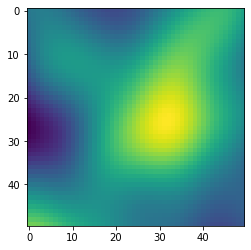

In [12]:
plt.imshow(sourceInfer[9])

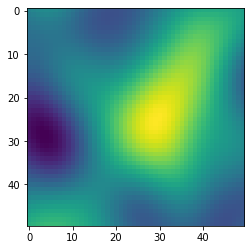

In [13]:
plt.imshow(sourceGT[9])

In [14]:
#plt.imshow(sourceFromCSV[9])

In [15]:
np.mean((sourceGT-sourceInfer)**2)

0.48794744640045234

In [16]:
#import csv
#np.savetxt("Observations16Sens5Times.csv", FullObs, delimiter=",")
#np.savetxt("GroundTruthSource16Sens5Times.csv", np.reshape(sourceGT,(res[0],res[1]*res[2])), delimiter=",")
#np.savetxt("GroundTruthConc16Sens5Times.csv", np.reshape(concTrain,(res[0],res[1]*res[2])), delimiter=",")

In [17]:
sourceFromCSV=np.genfromtxt("GroundTruthSource16Sens5Times.csv",delimiter=',')
sourceFromCSV=np.reshape(sourceFromCSV,(50,50,50))

# GP Comparison

In [18]:
import GPy

In [19]:
sensWindX = np.ravel_multi_index(m.getGridCoord(XGP).transpose(), np.asarray(m.u[0]).shape)
sensWindY = np.ravel_multi_index(m.getGridCoord(XGP).transpose(), np.asarray(m.u[1]).shape)
xwind=np.asarray(m.u).take(sensWindX)
ywind=np.asarray(m.u).take(sensWindY)

XGPwind = np.c_[XGP,xwind,ywind]

In [20]:
kGP = GPy.kern.RBF(3, name="rbf")

In [21]:
mGP = GPy.models.GPRegression(XGP, yTrain[:,None], kGP)
mGP 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [22]:
mGP.optimize()
mGP

GP_regression.,value,constraints,priors
rbf.variance,43.61904472553061,+ve,
rbf.lengthscale,2.8441337887307214,+ve,
Gaussian_noise.variance,3.3872738189781844e-06,+ve,


In [23]:
kGPwind = GPy.kern.RBF(5,ARD='true')
mGPwind = GPy.models.GPRegression(XGPwind, yTrain[:,None], kGPwind)
mGPwind 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,1.0,+ve,


In [24]:
mGPwind.optimize()
mGPwind

GP_regression.,value,constraints,priors
rbf.variance,34.15393466240109,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,0.12636616520126037,+ve,


In [25]:
meanGP, Cov = mGP.predict_noiseless(m.coords.transpose().reshape(50*50*50,3), full_cov=False)
meanGP=meanGP.reshape(50,50,50).transpose()

In [26]:
np.mean((meanGP-concTrain)**2)

1.6712601237493503

In [27]:
np.mean((concInfer-concTrain)**2)

2.6454475005557367

In [28]:
GPWindTest=np.c_[mPDE.coords.transpose().reshape(50*50*50,3),mPDE.u[0].flatten(),mPDE.u[1].flatten()]

In [29]:
meanGPWind, CovWind = mGPwind.predict_noiseless(GPWindTest, full_cov=False)
meanGPWind=meanGPWind.reshape(50,50,50).transpose()

In [30]:
np.mean((meanGPWind-concTrain)**2)

1.6180190304109292

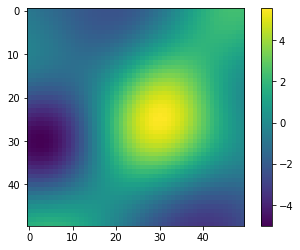

In [31]:
plt.imshow(meanGPWind[10])
plt.colorbar()

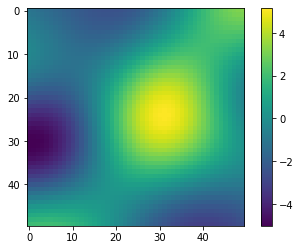

In [32]:
plt.imshow(meanGP[10])
plt.colorbar()

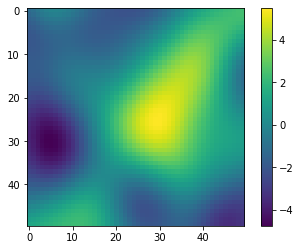

In [33]:
plt.imshow(concTrain[10])
plt.colorbar()

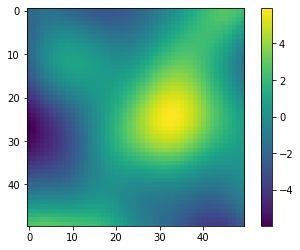

In [34]:
plt.imshow(concInfer[10])
plt.colorbar()

In [35]:
SourceCoords = np.c_[mPDE.coords.transpose().reshape(50*50*50,3),sourceGT.transpose().flatten()]

In [36]:
ConcCoords = np.c_[mPDE.coords.transpose().reshape(50*50*50,3),concTrain.transpose().flatten()]

In [37]:
ConcCoords

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.20408163,   0.        ,   0.        ,  -0.15155911],
       [  0.40816327,   0.        ,   0.        ,  -0.30477614],
       ...,
       [  9.59183673,  10.        ,  10.        ,  -9.73422056],
       [  9.79591837,  10.        ,  10.        , -10.00703839],
       [ 10.        ,  10.        ,  10.        , -10.28729938]])

In [38]:
concTrain[48,49,49]

-10.007038394036103

In [39]:
exactData = 

SyntaxError: invalid syntax (<ipython-input-39-0a633c000ff1>, line 1)

In [ ]:
concTrain[m.getGridCoord(XGP)].shape

In [ ]:
ravel = np.ravel_multi_index(m.getGridCoord(XGP).transpose(), np.asarray(concTrain).shape)

Data=np.asarray(concTrain).take(ravel)
noiseData = Data + np.random.normal(0,noiseSD,80)

exactData =  np.c_[XGP,Data]
noisyData = np.c_[XGP,noiseData]
testData = np.c_[m.getGridCoord(XGP),Data]

In [ ]:
#np.savetxt("exactObservations", exactData, delimiter=",")
#np.savetxt("noisyObservations", noisyData, delimiter=",")
#np.savetxt("GroundTruthSourceCoords", SourceCoords, delimiter=",")
#np.savetxt("GroundTruthConcCoords",ConcCoords, delimiter=",")

In [ ]:
exactData[3]

In [ ]:
noisyData[3]

In [ ]:
testData[0]

In [ ]:
concTrain[5,5,18]

In [ ]:
testData[1]

In [ ]:
testData[1][0:3]